In [ ]:
import yfinance as yf

btc = yf.download("BTC-USD", start="2020-01-01", end="2025-11-20")

# Load and import the data from yahoo

In [35]:
import yfinance as yf
import pandas as pd
import numpy as np

btc = yf.download("BTC-USD", start="2020-01-01", end="2025-11-20")


C:\Users\Owner\AppData\Local\Temp\ipykernel_14692\154957081.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", start="2020-01-01", end="2025-11-20")
[*********************100%***********************]  1 of 1 completed


### introduse base features

In [36]:
btc['Close_lag1'] = btc['Close'].shift(1)
btc['MA7'] = btc['Close'].rolling(7).mean()
btc['MA30'] = btc['Close'].rolling(30).mean()

In [37]:
# Bollinger Bands
btc['MA20'] = btc['Close'].rolling(20).mean()
btc['STD20'] = btc['Close'].rolling(20).std()
btc['BB_upper'] = btc['MA20'] + 2 * btc['STD20']
btc['BB_lower'] = btc['MA20'] - 2 * btc['STD20']

In [38]:
# Log returns
btc['log_return'] = np.log(btc['Close'] / btc['Close'].shift(1))

# Volatility (20-day)
btc['volatility20'] = btc['log_return'].rolling(20).std()

# High-Low percentage range
btc['hl_range'] = (btc['High'] - btc['Low']) / btc['Close']

# Volume change
btc['vol_change'] = btc['Volume'].pct_change()

# RSI 14

In [39]:
delta = btc['Close'].diff()
up = delta.clip(lower=0)
down = -delta.clip(upper=0)
roll_up = up.rolling(14).mean()
roll_down = down.rolling(14).mean()
RS = roll_up / roll_down
btc['RSI'] = 100 - (100 / (1 + RS))

# Clean up

In [40]:
btc = btc.dropna()

# feature selection

In [41]:
features = [
    'Close_lag1', 'MA7', 'MA30', 'MA20',
    'BB_upper', 'BB_lower', 'RSI',
    'log_return', 'volatility20', 'hl_range', 'vol_change'
]

X = btc[features]
y = btc['Close'].values.ravel()

# Train-test split

In [42]:
from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# normalize data

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# models


In [50]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
# from sklearn.ensemble import RandomForestRegressor
models = {
    "LinearRegression": ("scaled", LinearRegression()),
    "Ridge": ("scaled", Ridge()),
    "Lasso": ("scaled", Lasso())
}

results = {}

# train and evaluate

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

for name, (dtype, model) in models.items():
    if dtype == "scaled":
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train_raw, y_train)
        pred = model.predict(X_test_raw)

    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mse)

    results[name] = {
        "pred": pred,
        "mse": mse,
        "mae": mae,
        "rmse": rmse
    }

# print sorted
sorted_results = sorted(results.items(), key=lambda x: x[1]['rmse'])
for name, r in sorted_results:
    print(f"{name}: RMSE={r['rmse']:.2f}, MAE={r['mae']:.2f}")
    

Ridge: RMSE=1434.62, MAE=1057.19
LinearRegression: RMSE=1439.57, MAE=1048.09
Lasso: RMSE=1443.06, MAE=1048.32


# plotting

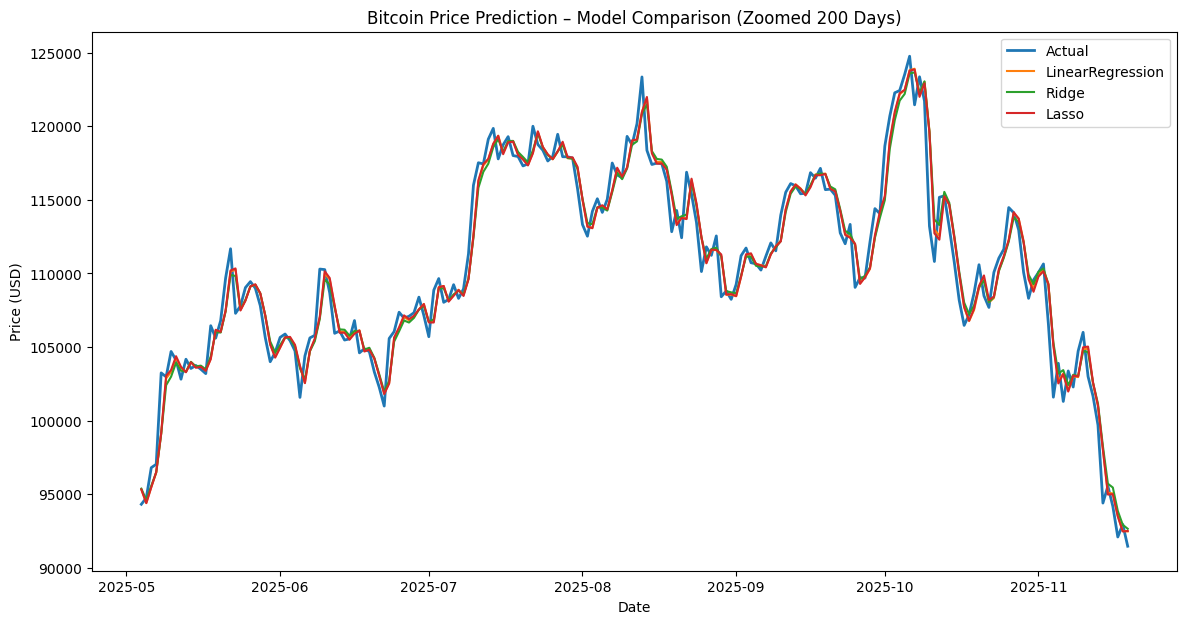

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,7))

last_n = 200

# get date index for test period
test_index = btc.index[int(len(btc)*0.8):]

# slice last N dates
plot_dates = test_index[-last_n:]

# plot actual
sns.lineplot(
    x=plot_dates,
    y=y_test[-last_n:],
    label="Actual",
    linewidth=2
)

# plot each model prediction
for name, r in results.items():
    sns.lineplot(
        x=plot_dates,
        y=r['pred'][-last_n:],
        label=name
    )

plt.title("Bitcoin Price Prediction – Model Comparison (Zoomed 200 Days)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()
